205. Day 2 - Finding Similar Products: Building a RAG Pipeline without LangChain  
8min  

week-08-205-Day-2-Finding-Similar-Products-Building-a-RAG-Pipeline-without-LangChain.md  
week-08-205-Day-2-Finding-Similar-Products-Building-a-RAG-Pipeline-without-LangChain.txt  


### loading LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B" from HF
#### will be used to predict price after learning from RAG Vector database for five similar price

In [ ]:
!pip install torch transformers accelerate huggingface_hub bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 43.6 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os
from huggingface_hub import login, whoami

# Get token from Colab secrets
hf_token = userdata.get('HF_TOKEN')

# Set environment variable
os.environ["HF_TOKEN"] = hf_token

# Log in to Hugging Face
login(token=hf_token, add_to_git_credential=True)

# Confirm login worked
print(whoami())

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


{'type': 'user', 'id': '68026f1e878852389f92c129', 'name': 'rbpal', 'fullname': 'Rajendra Pal', 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': '/avatars/f1ac536cbee359d6f6029422a07d183a.svg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'HF_TOKEN', 'role': 'fineGrained', 'createdAt': '2025-05-05T09:22:46.348Z', 'fineGrained': {'canReadGatedRepos': True, 'global': ['discussion.write', 'post.write'], 'scoped': [{'entity': {'_id': '68026f1e878852389f92c129', 'type': 'user', 'name': 'rbpal'}, 'permissions': ['repo.content.read', 'repo.write', 'inference.serverless.write', 'inference.endpoints.infer.write', 'inference.endpoints.write', 'user.webhooks.read', 'user.webhooks.write', 'collection.read', 'collection.write', 'discussion.write', 'user.billing.read']}]}}}}


In [ ]:
# ---- GPU checks (L4) ----
import torch
assert torch.cuda.is_available(), "CUDA GPU not found. In Colab: Runtime → Change runtime type → GPU."
gpu_name = torch.cuda.get_device_name(0)
print("GPU:", gpu_name)
# Prefer L4 but continue if another CUDA GPU is present
if "L4" not in gpu_name:
    print("⚠️ Non-L4 GPU detected; proceeding on CUDA anyway.")


GPU: NVIDIA L4


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Meta-Llama-3.1-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"
)


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
# testing model
# Set the Llama 3 chat template
tokenizer.chat_template = "{% for message in messages %}{% if message['role'] == 'user' %}{{ '<|start_header_id|>user<|end_header_id|>\n\n' + message['content'] + '<|eot_id|>' }}{% elif message['role'] == 'assistant' %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' + message['content'] + '<|eot_id|>' }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' }}{% endif %}"

messages = [
    {"role": "user", "content": "What is the capital of France?"}
]

# Apply chat template
prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

# Tokenize and move to GPU
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate output
outputs = model.generate(
    **inputs,
    max_new_tokens=10, # Reduce this
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    repetition_penalty=1.2
)

# Get only the NEW generated tokens (not the input prompt)
input_length = inputs['input_ids'].shape[1]
generated_ids = outputs[0][input_length:]
full_answer = tokenizer.decode(generated_ids, skip_special_tokens=True)

# print first line only
answer = full_answer.split('\n')[0].strip()
print("Answer:", answer)

Answer: Paris


 those are the steps to diagnose and fix the installation error.

Here's the logical sequence you followed:

1.  **Diagnosis:** You ran `!nvcc --version` to determine that your Colab runtime is using **CUDA version 12.5**. This was the necessary step to diagnose why the original `cuml-cuda11` package failed (it was the wrong version).
2.  **Fix:** Based on the diagnosis, you updated the installation commands to use the packages compatible with CUDA 12.x: `cudf-cu12` and `cuml-cu12`.

### Summary of the Correct Procedure

To successfully install the GPU-accelerated t-SNE in your current Colab environment:

1.  **Verify CUDA Version (Diagnosis):**
    ```python
    !nvcc --version
    ```
2.  **Install Dependencies (Fix):**
    ```python
    !pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
    !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
    ```
3.  **Restart Runtime (Crucial Final Step):** After installing large low-level libraries like these, it is **highly recommended** that you go to **Runtime \> Restart runtime** in the Colab menu. This ensures the new libraries and their dependencies are correctly loaded into your Python environment before you try to import and use them.

Once the runtime is restarted, you can proceed with using the `cuml.manifold.TSNE` code.

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
# !pip install cuml-cuda11 --extra-index-url=https://pypi.nvidia.com

# !pip install --upgrade "cuml>=24.4.0" --extra-index-url=https://pypi.nvidia.com

!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [ ]:

# pip installs
!pip install -q chromadb Items

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 10.7 MB/s 

You need the `import torch` and the subsequent print statements for two main reasons: **Initialization** and **Verification** of your GPU environment in Colab.

This code block ensures that the necessary foundation for high-performance computing (PyTorch) is loaded and that the system has correctly identified and connected to your GPU accelerator (like the L4 or A100).

***

## 1. Initialization (`import torch`)

* **PyTorch Foundation:** The line `import torch` loads the entire **PyTorch** deep learning framework. PyTorch is the underlying library that the `SentenceTransformer` uses for all its heavy lifting, including matrix multiplication and model loading.
* **CUDA Initialization:** When PyTorch is loaded, it automatically tries to initialize the CUDA driver on the Colab VM. If you are using a GPU runtime, this step is essential to prepare the GPU for accelerated computing.

***

## 2. Verification (`print` Statements)

These lines are used to confirm that the initialization was successful and to give you confidence in the runtime configuration.

| Code Line | What It Does | Why It's Needed |
| :--- | :--- | :--- |
| `print(f"CUDA available: {torch.cuda.is_available()}")` | Checks the CUDA status. | Confirms that the GPU accelerator is active and recognized by PyTorch. This should output `True` if you selected a GPU runtime. |
| `print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")` | Identifies the GPU model. | Tells you *which* GPU is allocated (e.g., 'NVIDIA A100', 'NVIDIA L4', 'Tesla T4'). This is vital because different GPUs offer drastically different performance (as you saw when vectorizing the 400k dataset).  |

In [ ]:
# Check GPU availability

import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")


CUDA available: True
GPU device: NVIDIA L4


### Conecet to Google Drive

In [ ]:
# Mount Google Drive first
from google.colab import drive
import os


# unmount if already drive mounted
drive.flush_and_unmount()

# remount
drive.mount('/content/drive', force_remount=True)

# Now navigate to your folder

os.chdir('/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system')

# Get current working directory (should show full path now)
print(f"Current directory: {os.getcwd()}")

# List contents
print("\nContents:")
for item in os.listdir('.'):
    print(f"  📁 {item}" if os.path.isdir(item) else f"  📄 {item}")

# To get the full path to a file in your current directory
file_path = os.path.join(os.getcwd(), '202_week8_day2_CUDA-code-chroma_vector_db_advanced_rag_pipeline.ipynb')
print(f"Full path: {file_path}")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
Current directory: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system

Contents:
  📁 agents
  📁 data
  📁 scripts
  📄 130_131_week6_01_buildDatasetAgain.ipynb
  📄 136_week6_01_useThis_buildDatasetAgain.ipynb
  📄 138_week6_day2_convertedOldPickelToNew.ipynb
  📁 products_vectorstore
  📄 202_week8_day2_chroma_vector_db_advanced_rag_pipeline.ipynb
  📄 202_week8_day2_CUDA-code-chroma_vector_db_advanced_rag_pipeline.ipynb
  📄 205_week8_day2_test_RAG_pipeline.ipynb
Full path: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/202_week8_day2_CUDA-code-chroma_vector_db_advanced_rag_pipeline.ipynb


In [ ]:
# imports
import sys

base_path = '/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system'
# Change working directory to project root
os.chdir(base_path)
print("Current working directory:", os.getcwd())
print("sys.path:", sys.path)
print("Does scripts folder exist?", os.path.exists(os.path.join(base_path, 'scripts')))

# # Add to Python path (optional but recommended)
sys.path.insert(0, os.path.join(base_path, 'scripts'))

# Create __init__.py in scripts folder to make it a package
init_file = os.path.join(base_path, 'scripts', '__init__.py')
if not os.path.exists(init_file):
    with open(init_file, 'w') as f:
        f.write('')

import re
import math
import json
import random
from dotenv import load_dotenv
from datetime import datetime
import pickle

from tqdm import tqdm
from google.colab import userdata
# from huggingface_hub import login, whoami
# from datasets import load_dataset, Dataset, DatasetDict

import torch
from sentence_transformers import SentenceTransformer

import chromadb

from preprocess_data import Item

from testing import Tester

from sklearn.manifold import TSNE

import numpy as np
import plotly.graph_objects as go





Current working directory: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system
sys.path: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/tmp/tmpcdjkh3z2']
Does scripts folder exist? True


## List data folder

In [ ]:
import os

data_folder = '/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system'

def format_size(size_bytes):
    """Convert bytes to human readable format"""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_bytes < 1024.0:
            return f"{size_bytes:.2f} {unit}"
        size_bytes /= 1024.0
    return f"{size_bytes:.2f} TB"

print(f"\n📂 Contents of: {data_folder}\n")
print("=" * 80)

# Get all items in data folder
items = os.listdir(data_folder)

# Separate folders and files
folders = []
files = []

for item in items:
    full_path = os.path.join(data_folder, item)
    if os.path.isdir(full_path):
        folders.append(item)
    else:
        files.append(item)

# Display folders first
for folder in sorted(folders):
    folder_path = os.path.join(data_folder, folder)
    print(f"\n📁 {folder}/")

    # List items inside this folder
    try:
        sub_items = os.listdir(folder_path)
        for sub_item in sorted(sub_items):
            sub_path = os.path.join(folder_path, sub_item)
            if os.path.isfile(sub_path):
                size = os.path.getsize(sub_path)
                print(f"   📄 {sub_item:40s} {format_size(size):>12s}")
            else:
                # It's a nested folder - show its contents too
                print(f"   📁 {sub_item}/")
                try:
                    nested_items = os.listdir(sub_path)
                    for nested_item in sorted(nested_items):
                        nested_file_path = os.path.join(sub_path, nested_item)
                        if os.path.isfile(nested_file_path):
                            size = os.path.getsize(nested_file_path)
                            print(f"      📄 {nested_item:37s} {format_size(size):>12s}")
                except PermissionError:
                    print(f"      ⚠️  Permission denied")
    except PermissionError:
        print(f"   ⚠️  Permission denied")

# Display files in root data folder
if files:
    print(f"\n📄 Files in root:")
    for file in sorted(files):
        file_path = os.path.join(data_folder, file)
        size = os.path.getsize(file_path)
        print(f"   {file:40s} {format_size(size):>12s}")

print("\n" + "=" * 80)

# Total size
total_size = 0
for root, dirs, files_list in os.walk(data_folder):
    for file in files_list:
        file_path = os.path.join(root, file)
        total_size += os.path.getsize(file_path)

print(f"\n📊 Total size: {format_size(total_size)}")


📂 Contents of: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system


📁 agents/

📁 data/
   📁 final_v_02/
      📄 test.pkl                                  37.72 MB
      📄 train.pkl                                560.36 MB

📁 products_vectorstore/
   📁 11d4a57a-e300-4096-ad10-58d9d1cc8560/
      📄 data_level0.bin                          638.32 MB
      📄 header.bin                                100.00 B
      📄 index_metadata.pickle                     15.02 MB
      📄 length.bin                                 1.52 MB
      📄 link_lists.bin                             3.23 MB
   📄 chroma.sqlite3                                1.77 GB

📁 scripts/
   📄 __init__.py                                    0.00 B
   📁 __pycache__/
      📄 __init__.cpython-312.pyc                  181.00 B
      📄 items.cpython-312.pyc                      5.63 KB
      📄 loaders.cpython-312.pyc                    4.91 KB
      📄 loaders_for_colab.cpython-312.pyc          5.33 KB
      📄 loaders_

## Copy dataset from Pickle file format to Colab VM for faster access

 We can significantly speed up the data loading by first copying the entire data folder from Google Drive to the Colab VM's local, high-speed disk (/content/) before opening the files.

In [ ]:
# Load the new pickle files (like the author does)
print("="*70)
print("LOADING NEW PICKLE FILES")
print("="*70)

# --- START OPTIMIZATION ---

# 1. Define the SOURCE path on Google Drive
drive_data_folder = "/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/data/final_v_02"

# 2. Define the DESTINATION path on the local Colab disk
local_data_folder = "/content/final_data"

# 3. Use the 'cp -r' command to copy the entire folder from Drive to the local disk
print(f"Copying data from Google Drive to local disk ({local_data_folder})...")
!cp -r "$drive_data_folder" "$local_data_folder"
print("✓ Copy complete.")

# 4. Update the 'data_folder' variable to point to the FAST, local path
data_folder = local_data_folder

# --- END OPTIMIZATION ---


import os
import pickle # Added to ensure pickle is defined

# Load files from the FAST local disk
with open(os.path.join(data_folder, "train.pkl"), 'rb') as file:
    train = pickle.load(file)

with open(os.path.join(data_folder, "test.pkl"), 'rb') as file:
    test = pickle.load(file)


print(f"✓ Loaded train: {len(train)} items")
print(f"✓ Loaded test: {len(test)} items")

LOADING NEW PICKLE FILES
Copying data from Google Drive to local disk (/content/final_data)...
✓ Copy complete.
✓ Loaded train: 400000 items
✓ Loaded test: 26934 items


## Looking into Train dataset

In [ ]:
len(train)

400000

In [ ]:
train[1]

<GASLAND Chef ES609MBN1 Single Wall Oven, 24" Built-in Electric Wall Oven, 240V 3200W 2.3Cu.f Convection Wall Oven with Rotisserie, 9 Cooking Modes, Mechanical Knob Control, Transparent Window, Black = $569.99>

In [ ]:
train[0].prompt

'How much does this cost to the nearest dollar?\n\nFront Strut Coil Spring Sway Bar Link Kit - 4 Piece - Compatible with 2010-2016 Cadillac SRX (without RPO Code F45)\nFront Strut Coil Spring Sway Bar Link Kit 4 Piece Set - Compatible with 2010 - 2016 Cadillac SRXPosition  FrontNote  Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time Damping Chassis Quantity  4 Piece SetPackage Contents  Sway Bar LinksFeatures   - Matched Parts - Pre-AssembledCompatible With or Fits   - 2010 - 2016 Cadillac SRX Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time\n\nPrice is $269.00'

In [ ]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split('\n\nPrice is $')[0]

In [ ]:
description(train[0])

'Front Strut Coil Spring Sway Bar Link Kit - 4 Piece - Compatible with 2010-2016 Cadillac SRX (without RPO Code F45)\nFront Strut Coil Spring Sway Bar Link Kit 4 Piece Set - Compatible with 2010 - 2016 Cadillac SRXPosition  FrontNote  Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time Damping Chassis Quantity  4 Piece SetPackage Contents  Sway Bar LinksFeatures   - Matched Parts - Pre-AssembledCompatible With or Fits   - 2010 - 2016 Cadillac SRX Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time'

## Looking into Test dataset

In [ ]:
len(test)

26934

In [ ]:
test[0]

<Sony Dt 55-200mm F4-5.6 SAM SAL55200-2 - International Version (No Warranty) = $82.99>

In [ ]:
test[0].prompt

'How much does this cost to the nearest dollar?\n\nSony Dt 55-200mm F4-5.6 SAM SAL55200-2 - International Version (No Warranty)\nThis is an international version  an international version item is a product not originally intended for sale in the U.S. Depending on the country of origin,, international versions of a product may differ from domestic versions in their default settings,, packaging,, AC adapters,, accessories,, Manufacturer warranties,, and other features. Lens  "Product Dimensions"  "9 x 7 x 5 inches",, "Item Weight"  "10.8 ounces",, "Item model number"  "Is Discontinued By Manufacturer"  "No",, "Date First Available"  "September 13,, "Manufacturer"  "Sony",, "Brand"  "Sony",,\n\nPrice is $83.00'

# Below code is to create Vector database, but we are skipping below step as Vector databse already exist, created previosly

In [ ]:
# import chromadb
# import os

# # Use the existing folder path from your Drive
# DB = "products_vectorstore"
# # db_path = "/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/products_vectorstore"

# # Use the Colab content directory for fast local storage
# db_path = f"/content/{DB}"

# # Create client
# # Initializes the ChromaDB client. The use of PersistentClient means that all data added to the database will be saved to the specified db_path folder.
# client = chromadb.PersistentClient(path=db_path)


# # Check and delete collection if exists

# # Sets the name of the vector collection i.e. "products"(similar to a table in a traditional database) that will store your product vectors.
# collection_name = "products"

# existing_collection_names = [collection.name for collection in client.list_collections()]


# # Checks if the "products" collection is in the list of existing collections.If the collection "products" exists, it is permanently deleted.
# if collection_name in existing_collection_names:
#     client.delete_collection(collection_name)
#     print(f"Deleted old collection: {collection_name}")

# # Create collection
# # Creates a new, empty vector collection named "products" and assigns the resulting collection object to the collection variable. This object is what you use to add, query, or delete vectors.
# collection = client.create_collection(collection_name)
# print(f"✓ Collection '{collection_name}' created at {db_path}")

✓ Collection 'products' created at /content/products_vectorstore


Certainly. This single list comprehension line is a very efficient and Pythonic way to perform a two-step operation on the ChromaDB client: **retrieve data** and then **extract a specific attribute** from that data.

The line you're asking about is:

```python
existing_collection_names = [collection.name for collection in client.list_collections()]
```

-----

## Detailed Breakdown

This code is equivalent to a short loop, and it breaks down into two main parts:

### 1\. The Function Call: `client.list_collections()`

  * **Action:** When you call `client.list_collections()`, the ChromaDB client connects to the underlying database (which, in your case, is the persistent file store on the local Colab disk).
  * **Output:** This function returns a **list of collection objects**. Each object in this list is a structured container representing a collection currently stored in the database.
  * **Example Output (Conceptual):** The client doesn't return names directly; it returns structured objects. Imagine the output looks conceptually like this:
    ```
    [
        <chromadb.api.models.Collection(id=uuid1, name='products', count=40000)>,
        <chromadb.api.models.Collection(id=uuid2, name='temp_vectors', count=100)>
    ]
    ```

### 2\. The List Comprehension: `[collection.name for collection in ...]`

The list comprehension iterates over the list of collection objects returned in the previous step and extracts only the name.

| Part of Code | Python's Action | Resulting Value (for one collection) |
| :--- | :--- | :--- |
| `for collection in ...` | Python iterates through the list of collection objects returned by `list_collections()`. | The variable `collection` temporarily holds one collection object at a time. |
| `collection.name` | Python accesses the `.name` attribute (the string name) of the current collection object. | `'products'` or `'temp_vectors'` |
| `[...]` | Python adds the extracted name to the new list, `existing_collection_names`. | `['products', 'temp_vectors']` |

## Summary

The entire operation efficiently transforms the complex list of ChromaDB collection objects into a simple, flat list of strings, making it easy to check if your desired collection name (`"products"`) exists using the standard Python `in` operator.

You want to update the previous code to use the specific Google Drive path shown in the image when defining the source and destination for saving/loading the vector database.

Here is the updated code snippet for **saving (copying)** the vector database from the fast local Colab disk back to your Google Drive path.

-----

## Updated Code to Save to Google Drive

This code assumes you have successfully created your vector database in the local Colab folder: `/content/products_vectorstore`. It ensures the final, permanent copy is saved to the location shown in your image.

```python
# 1. Define the source (local Colab disk) and destination (Google Drive) paths

# The vector database folder created during the session
local_db_folder = "/content/products_vectorstore"

# The precise Google Drive folder path from your image:
# 'My Drive > 01-LLM-ed-donner > build_multi_agent_system'
# We are copying the 'products_vectorstore' folder INTO this directory.
drive_db_destination = "/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/"

print("="*70)
print("SAVING VECTOR DATABASE from local disk to Google Drive...")
print(f"Source: {local_db_folder}")
print(f"Destination: {drive_db_destination}")
print("="*70)

# 2. Use the 'cp -r' command to copy the entire folder
# This will overwrite the existing 'products_vectorstore' folder in your Drive path
!cp -r "$local_db_folder" "$drive_db_destination"

print("✓ Database saved permanently to Google Drive.")
```

-----

## How to Reuse the Database (Loading in a New Session)

For completeness, here is the corresponding code you would use in a **new Colab session** to quickly load the saved database back to the fast local disk:

```python
import chromadb
# 1. Define paths

# The precise Google Drive folder path where the database is stored
drive_db_source = "/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/products_vectorstore"

# The fast local disk path for operation
local_db_path = "/content/products_vectorstore"

# 2. Copy the database from Drive to the local disk
print("Loading database from Drive to local disk for fast access...")
# We copy the source folder INTO /content/
!cp -r "$drive_db_source" /content/
print("✓ Load complete.")

# 3. Create ChromaDB Client connected to the local copy
client = chromadb.PersistentClient(path=local_db_path)

# You can now retrieve the collection and use it instantly
collection = client.get_or_create_collection('products')
print("Client connected to the fast local copy.")
print(f"Collection count: {collection.count()} items")
```

# cp vector database to colab VM for faster performance

In [ ]:
import chromadb
# 1. Define paths

# The precise Google Drive folder path where the database is stored
drive_db_source = "/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/products_vectorstore"

# The fast local disk path for operation
local_db_path = "/content/products_vectorstore"

# 2. Copy the database from Drive to the local disk
print("Loading database from Drive to local disk for fast access...")
# We copy the source folder INTO /content/
!cp -r "$drive_db_source" /content/
print("✓ Load complete.")

# 3. Create ChromaDB Client connected to the local copy
client = chromadb.PersistentClient(path=local_db_path)

# You can now retrieve the collection and use it instantly
collection = client.get_or_create_collection('products')
print("Client connected to the fast local copy.")
print(f"Collection count: {collection.count()} items")

Loading database from Drive to local disk for fast access...
✓ Load complete.
Client connected to the fast local copy.
Collection count: 400000 items


**SentenceTransformer Tokenizer & Embeddings:**

**Tokenizer:**
- Converts text → token IDs (integers)
- Uses BERT-style tokenization (WordPiece)
- Max length: typically 512 tokens
- Adds special tokens: `[CLS]`, `[SEP]`

**Dimensions:**
- Popular models:
  - `all-MiniLM-L6-v2`: **384 dimensions**
  - `all-mpnet-base-v2`: **768 dimensions**
  - `multi-qa-mpnet-base`: **768 dimensions**

**Dense Vector:**
- Single continuous vector representing entire sentence
- Example: `[0.23, -0.45, 0.89, ..., 0.12]` (384 or 768 floats)
- Each dimension captures semantic meaning
- Used for similarity: cosine similarity between vectors

**Quick example:**
```python
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embedding = model.encode("Hello world")

print(embedding.shape)  # (384,)
print(type(embedding))  # numpy array
```

Dense = all values are meaningful (vs sparse where most are 0).


** Each **sentence/text** gets ONE 384-dim embedding, not each word.

**Key difference:**

**SentenceTransformer:**
- Input: "Hello world"
- Output: **ONE vector** [0.23, -0.45, ..., 0.12] (384 dims)
- Represents the **entire sentence**

**Word embeddings (Word2Vec, GloVe):**
- Input: "Hello world"
- Output: **TWO vectors**
  - "Hello" → [0.1, 0.2, ...]
  - "world" → [0.3, 0.4, ...]
- Each word gets its own vector

**Example:**
```python
model = SentenceTransformer('all-MiniLM-L6-v2')

text = "This is a long sentence with many words"
embedding = model.encode(text)

print(embedding.shape)  # (384,) - ONE vector for entire text
```

Doesn't matter if 5 words or 100 words → always ONE 384-dim vector.

In [ ]:
# Load model on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [ ]:
train[0]

<Front Strut Coil Spring Sway Bar Link Kit - 4 Piece - Compatible with 2010-2016 Cadillac SRX (without RPO Code F45) = $268.95>

In [ ]:
train[0].prompt

'How much does this cost to the nearest dollar?\n\nFront Strut Coil Spring Sway Bar Link Kit - 4 Piece - Compatible with 2010-2016 Cadillac SRX (without RPO Code F45)\nFront Strut Coil Spring Sway Bar Link Kit 4 Piece Set - Compatible with 2010 - 2016 Cadillac SRXPosition  FrontNote  Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time Damping Chassis Quantity  4 Piece SetPackage Contents  Sway Bar LinksFeatures   - Matched Parts - Pre-AssembledCompatible With or Fits   - 2010 - 2016 Cadillac SRX Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time\n\nPrice is $269.00'

In [ ]:
def description(item):
  text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
  return text.split("\n\nPrice is $")[0]

In [ ]:
# note we just get the desription of the product
# note - vector database below we are cearting will have only description of products. note No Price of item.
description(train[0])

'Front Strut Coil Spring Sway Bar Link Kit - 4 Piece - Compatible with 2010-2016 Cadillac SRX (without RPO Code F45)\nFront Strut Coil Spring Sway Bar Link Kit 4 Piece Set - Compatible with 2010 - 2016 Cadillac SRXPosition  FrontNote  Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time Damping Chassis Quantity  4 Piece SetPackage Contents  Sway Bar LinksFeatures   - Matched Parts - Pre-AssembledCompatible With or Fits   - 2010 - 2016 Cadillac SRX Front; without RPO Code F45  Real Time Damping Chassis ; Except RPO Code F45  Real Time'

## Python Function for Generating Product Context

```python
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message
```

-----

## Code Explanation

This Python code defines a function called `make_context` that takes two lists as input: `similars` (a list of product names or descriptions) and `prices` (a corresponding list of prices for those products). Its purpose is to create a formatted text string that lists these similar items and their prices to provide contextual information.

### Components

1.  **Function Definition:** `def make_context(similars, prices):` defines the function which accepts two arguments, presumably lists of the same length.
2.  **Initialization:** `message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"` initializes the output string with a standard introductory sentence, followed by two newline characters (`\n\n`) for spacing.
3.  **Iteration:** `for similar, price in zip(similars, prices):` iterates through both the `similars` and `prices` lists simultaneously using the `zip()` function. In each iteration, it assigns a product name/description to `similar` and its price to `price`.
4.  **String Concatenation:** `message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"` appends (adds to) the `message` string in each loop.
      * It uses an **f-string** for formatting.
      * `\n` inserts a newline for better readability.
      * `{price:.2f}` formats the price to always show **two decimal places** (standard currency format).
5.  **Return Value:** `return message` outputs the final, formatted string containing the initial context statement followed by the list of similar products and their prices.

In [ ]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

## Python Function for Creating Contextual Price Estimation Messages

```python
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "\nAnd now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]
```

-----

## Code Explanation

The Python code defines a function named `messages_for` which is designed to construct a structured list of messages, likely for use with a **conversational AI model** (like a large language model). This setup provides the model with context to estimate the price of a target item.

### Components

1.  **Function Definition:** `def messages_for(item, similars, prices):` accepts three arguments:
      * `item`: An object (or similar structure) representing the item whose price needs to be estimated.
      * `similars`: A list of similar product names/descriptions.
      * `prices`: A list of corresponding prices for the similar products.
2.  **`system_message`:** `system_message = "You estimate prices of items. Reply only with the price, no explanation"` sets the instructions for the AI model, telling it its role is to estimate prices and specifying the desired output format (price only).
3.  **Context Generation:** `user_prompt = make_context(similars, prices)` calls a presumed external function (`make_context`, as seen in the previous example) to generate the introductory text listing the similar products and their prices. This provides the AI with **contextual data**.
4.  **Prompt Construction:**
      * `user_prompt += "\nAnd now the question for you:\n\n"` adds a transition phrase to separate the context from the question.
      * `user_prompt += item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")` appends the actual question about the target item's price.
          * It retrieves the question text using `item.test_prompt()`.
          * It then cleans up the question by using the **`.replace()`** method twice to remove specific phrases: `" to the nearest dollar"` and `"\\n\\nPrice is $"` (which might be included in the original prompt template).
5.  **Return Value (Message List):** The function returns a **list of dictionaries**, which is the standard format for passing conversation history or prompt segments to many modern AI APIs:
      * **`{"role": "system", "content": system_message}`:** Sets the overall behavior and constraints for the model.
      * **`{"role": "user", "content": user_prompt}`:** Contains the full prompt and context generated for the model to process.
      * **`{"role": "assistant", "content": "Price is $"}`:** Provides a **partial start to the AI's expected response**, priming it to output only the dollar amount immediately following "Price is $" (due to the strict instructions in the system message).

In [ ]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "\nAnd now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [ ]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split('\n\nPrice is $')[0]

In [ ]:
test[0]

<Sony Dt 55-200mm F4-5.6 SAM SAL55200-2 - International Version (No Warranty) = $82.99>

In [ ]:
test[0].prompt

'How much does this cost to the nearest dollar?\n\nSony Dt 55-200mm F4-5.6 SAM SAL55200-2 - International Version (No Warranty)\nThis is an international version  an international version item is a product not originally intended for sale in the U.S. Depending on the country of origin,, international versions of a product may differ from domestic versions in their default settings,, packaging,, AC adapters,, accessories,, Manufacturer warranties,, and other features. Lens  "Product Dimensions"  "9 x 7 x 5 inches",, "Item Weight"  "10.8 ounces",, "Item model number"  "Is Discontinued By Manufacturer"  "No",, "Date First Available"  "September 13,, "Manufacturer"  "Sony",, "Brand"  "Sony",,\n\nPrice is $83.00'

In [ ]:
description(test[0])

'Sony Dt 55-200mm F4-5.6 SAM SAL55200-2 - International Version (No Warranty)\nThis is an international version  an international version item is a product not originally intended for sale in the U.S. Depending on the country of origin,, international versions of a product may differ from domestic versions in their default settings,, packaging,, AC adapters,, accessories,, Manufacturer warranties,, and other features. Lens  "Product Dimensions"  "9 x 7 x 5 inches",, "Item Weight"  "10.8 ounces",, "Item model number"  "Is Discontinued By Manufacturer"  "No",, "Date First Available"  "September 13,, "Manufacturer"  "Sony",, "Brand"  "Sony",,'

## Python Function for Item Vectorization

```python
def vector(item):
    return model.encode([description(item)])
```

-----

## Code Explanation

This concise Python function, **`vector(item)`**, is designed to generate a **vector representation** (or **embedding**) for a given item, a common task in machine learning and information retrieval.

### Components

1.  **Function Definition:** `def vector(item):` defines the function that accepts a single argument, **`item`**, which represents the object or data structure whose description is to be vectorized.
2.  **Description Extraction:** `description(item)` is a call to another function (presumed to be defined elsewhere) that extracts the relevant textual **description** from the input `item`.
3.  **Encoding/Vectorization:** `model.encode(...)` is the core operation.
      * **`model`** is a presumed external object (likely an instance of a pre-trained **transformer model** or sentence embedding model like S-BERT, or a similar embedding framework).
      * The `description(item)` is passed inside a **list** (`[...]`) to the `encode` method, as these models often expect a list of strings (even if it's a list with only one string) as input.
      * The `encode` method processes the text and converts it into a **dense numerical vector** (an array of numbers) that captures the semantic meaning of the description.
4.  **Return Value:** The function \*\*`return`\*\*s this generated vector, which is used to represent the item in a high-dimensional space where items with similar meanings are mapped closer together.


That function snippet, **`def description(item):`**, is designed to extract a clean item description from a text field within an `item` object, specifically by stripping away common prompt and price components often used in price estimation tasks.

Here is the function converted to text and added to the documentation, with a complete explanation and concise title.

-----

## Python Function for Item Description Extraction

```python
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split('\n\nPrice is $')[0]
```

*(Note: I've corrected a likely syntax error in the original prompt's function by removing the trailing dot (`.`) after `[0]`.)*

-----

## Code Explanation

This function, **`description(item)`**, takes an `item` object (likely a structured data type used in a machine learning or data pipeline) and isolates the core textual description of the product from a larger formatted prompt string.

### Components

1.  **Function Definition:** `def description(item):` defines the function, accepting one argument, **`item`**, which is explained below to have a property or attribute named `prompt`.
2.  **Removing the Question:**
      * `text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")` accesses the full prompt text via `item.prompt`.
      * It then uses the **`.replace()`** method to find and remove a specific question string, `"How much does this cost to the nearest dollar?\n\n"`, from the beginning of the prompt. This leaves the item's description potentially followed by price placeholders or other cleanup text.
3.  **Splitting and Isolating the Description:**
      * `return text.split('\n\nPrice is $')[0]` performs the final cleanup and extraction.
      * The **`.split()`** method divides the remaining `text` string into a list of substrings, using the phrase `'\n\nPrice is $'` as the delimiter. This phrase is often found *after* the description and *before* the price value in many datasets.
      * By selecting the first element of the resulting list (`[0]`), the function isolates and returns **only the text that precedes** the price placeholder, which is the clean product description itself.

This function is essential for the `vector(item)` function (previously documented), as it ensures that the model only encodes the semantic information of the item description and not the extraneous prompt or price template text.

In [ ]:
def vector(item):
    return model_sentence_transformer.encode([description(item)])

## Python Function for Finding Similar Items

```python
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices
```

-----

## Code Explanation

This Python function, **`find_similars(item)`**, is designed to query a vector database (represented by `collection`) to find items that are semantically similar to a given **`item`** and retrieve their descriptions and prices. This is a common operation in recommendation systems or context generation tasks.

### Components

1.  **Function Definition:** `def find_similars(item):` defines the function that takes one argument, the target **`item`**.
2.  **Vector Query and Retrieval:**
      * `results = collection.query(...)` executes a similarity search against the **`collection`** object (which is an assumed vector store or database).
      * **`query_embeddings=vector(item).astype(float).tolist()`:** This is the search query. It first calls the presumed **`vector(item)`** function (as seen in previous examples) to get the numerical embedding (vector) of the target item. It then ensures the vector's data type is **`float`** and converts it to a standard Python **`list`** format, which is required for the query.
      * **`n_results=5`:** Specifies that the search should return the **top 5** most similar items found in the collection.
3.  **Extracting Documents (Item Descriptions):**
      * `documents = results['documents'][0][:]` extracts the list of retrieved document strings (the descriptions of the similar items) from the query `results`.
      * The results are structured: `results['documents']` is a list where the first element (`[0]`) is the list of documents corresponding to the first query (since only one query vector was provided).
4.  **Extracting Prices (Metadata):**
      * `prices = [m['price'] for m in results['metadatas'][0][:]]` uses a **list comprehension** to extract the price for each similar item.
      * The `results['metadatas']` key holds a list of dictionaries associated with each document.
      * It iterates through the metadata dictionaries in the first result set (`results['metadatas'][0]`) and retrieves the value associated with the key **`'price'`** for each one.
5.  **Return Value:** `return documents, prices` returns two lists:
      * **`documents`**: A list of descriptions for the 5 most similar items.
      * **`prices`**: A list of the corresponding prices for those similar items.

In [ ]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [ ]:
test[1]

<BearHoHo Escape Room Props Puzzles Scale Sensor Put The Right Weight on Scale Sensor to Open 12V Electromagnetic Locks for Room Escape and Exit Game Owners (with Audio) = $140.0>

In [ ]:
test[1].prompt

'How much does this cost to the nearest dollar?\n\nBearHoHo Escape Room Props Puzzles Scale Sensor Put The Right Weight on Scale Sensor to Open 12V Electromagnetic Locks for Room Escape and Exit Game Owners (with Audio)\nThere is one controller with one weight sensors which room escape owners can installed in desk or wooden board,, players have to figure out the puzzle and find out the target weight,, and put the right object wanted weight on the weight sensor. If the scale sensor has been place the right weight,, the door will open. HIGHTLIGHTS 1. Support owner revise the trigger weight of your own.  2. Support users to change audio content  built-in TF card,, audio format MP3,, no more than 128M. PACKING LIST 1 x Controller 1 x 12V Power\n\nPrice is $140.00'

In [ ]:
documents, prices = find_similars(test[0])

In [ ]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
SONY DT 18-135mm F3.5-5.6 SA Sony A-mount lens SAL18135 - International Version (No Warranty)
"Package Dimensions"  "7.72 x 4.88 x 4.8 inches",, "Item Weight"  "14.1 ounces",, "Item model number"  "Is Discontinued By Manufacturer"  "No",, "Date First Available"  "November 2,, "Manufacturer"  "Sony",, "Brand"  "Sony",, "Lens Type"  "Telephoto",, "Compatible Mountings"  "Sony A",, "Camera Lens Description"  mm",, "Maximum Focal Length"  "135 Millimeters"
Price is $254.52

Potentially related product:
SONY 75-300mm F4.5-5.6 SAL75300 - International Version (No Warranty)
SKU Used Sony  A-mnt Maxxum  Lens  "Product Dimensions"  "4.4 x 4.2 x 8.1 inches",, "Item Weight"  "1.01 pounds",, "Item model number"  "Best Sellers Rank"   "Camera Lenses"  7634,, "Is Discontinued By Manufacturer"  "No",, "Date First Available"  "June 17,, "Manufacturer"  "Sony",, "Bran

In [ ]:
print(messages_for(test[10], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nSONY DT 18-135mm F3.5-5.6 SA Sony A-mount lens SAL18135 - International Version (No Warranty)\n"Package Dimensions"  "7.72 x 4.88 x 4.8 inches",, "Item Weight"  "14.1 ounces",, "Item model number"  "Is Discontinued By Manufacturer"  "No",, "Date First Available"  "November 2,, "Manufacturer"  "Sony",, "Brand"  "Sony",, "Lens Type"  "Telephoto",, "Compatible Mountings"  "Sony A",, "Camera Lens Description"  mm",, "Maximum Focal Length"  "135 Millimeters"\nPrice is $254.52\n\nPotentially related product:\nSONY 75-300mm F4.5-5.6 SAL75300 - International Version (No Warranty)\nSKU Used Sony  A-mnt Maxxum  Lens  "Product Dimensions"  "4.4 x 4.2 x 8.1 inches",, "Item Weight"  "1.01 pounds",, "Item model number"  "Best Se

## 206. Day 2 - RAG Pipeline Implementation: Enhancing LLMs with Retrieval Techniques  
7min  

In [ ]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.?\d+", s)
    return float(match.group()) if match else 0

In [ ]:
def llama_rag(item):
    documents, prices = find_similars(item)
    context = make_context(documents, prices)

    # Simple prompt without chat template
    prompt = f"""You estimate prices. Reply only with the price number.

{context}

How much does this cost?
{description(item)}

Price is $"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    input_length = inputs['input_ids'].shape[1]
    reply = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True).strip()

    return get_price(reply)

1: Guess: $199.00 Truth: $82.99 Error: $116.01 SLE: 0.75 Item: Sony Dt 55-200mm F4-5.6 SAM SAL55200-2 -...
2: Guess: $79.00 Truth: $140.00 Error: $61.00 SLE: 0.32 Item: BearHoHo Escape Room Props Puzzles Scale...
3: Guess: $69.99 Truth: $91.00 Error: $21.01 SLE: 0.07 Item: Avaya Partner 18D Display Telephone Refu...
4: Guess: $98.99 Truth: $49.99 Error: $49.00 SLE: 0.45 Item: 5J.J3T05.001 Replacement Lamp Special Up...
5: Guess: $29.99 Truth: $11.00 Error: $18.99 SLE: 0.90 Item: Traxxas 3232X Super Duty Long Glow Plug,...
6: Guess: $65.00 Truth: $65.00 Error: $0.00 SLE: 0.00 Item: Bellroy Phone Case for iPhone 13 Pro wit...
7: Guess: $9.99 Truth: $136.15 Error: $126.16 SLE: 6.37 Item: Big Horn 19505 Preppin Weapon Kit - 5 As...
8: Guess: $11.99 Truth: $11.99 Error: $0.00 SLE: 0.00 Item: Evil Eye Popsocket for Phone Evil Eye Po...
9: Guess: $24.99 Truth: $25.99 Error: $1.00 SLE: 0.00 Item: 12 Pieces Mini Stuffed Forest Animals Ju...
10: Guess: $299.99 Truth: $449.00 Error: $149.01 SLE: 

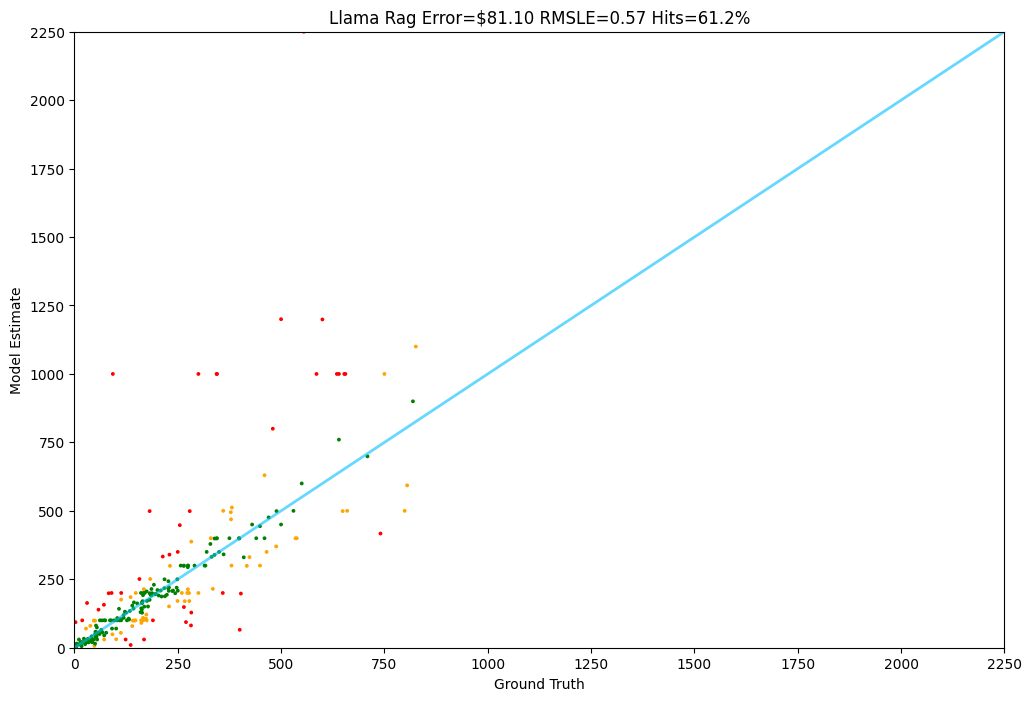

In [ ]:
Tester.test(llama_rag, test)

**Chart Analysis - Llama RAG Performance:**

**Metrics:**
- **Average Error: $81.10** - Not bad overall
- **RMSLE: 0.57** - Decent logarithmic error
- **Hits: 61.2%** - 61% of predictions within acceptable range (green dots)

**What the chart shows:**

1. **Low prices ($0-500): Good performance** ✓
   - Dense cluster of green dots near the blue line
   - Model predicts accurately for cheaper items

2. **High prices ($500+): Struggles significantly** ✗
   - Red/orange dots below the blue line
   - Model **underestimates** expensive items
   - Example: Truth=$1000, Guess=$500

3. **Pattern:** Model is biased toward lower prices
   - Probably because RAG finds more low-priced examples
   - Llama learns from those examples and predicts conservatively

**Why this happens:**
- Your database likely has more cheap items than expensive ones
- Few-shot examples (5 items) don't represent high-end products well
- Model plays it safe and predicts closer to average

**To improve:**
- Filter `find_similars` to match price range better
- Use more examples (10 instead of 5)
- Add price hints to the prompt

**Overall: 61% accuracy is decent for RAG + Llama few-shot!**

### mprovements

**Great thinking! Let's analyze both:**

**1. Better description + price matching ✓✓✓**
**YES! This is the BEST improvement.**

Currently `find_similars` only matches by semantic similarity. Add price-aware filtering:

```python
def find_similars(item):
    # Get more candidates
    results = collection.query(
        query_embeddings=model_sentence_transformer.encode(description(item)).tolist(),
        n_results=20  # Get more first
    )
    
    documents = results['documents'][0][:]
    metadatas = results['metadatas'][0][:]
    
    # Estimate price range from top results
    top_prices = [float(m['price']) for m in metadatas[:5]]
    avg_price = sum(top_prices) / len(top_prices)
    
    # Filter by price range (±50%)
    filtered = []
    for doc, meta in zip(documents, metadatas):
        price = float(meta['price'])
        if 0.5 * avg_price <= price <= 1.5 * avg_price:
            filtered.append((doc, price))
        if len(filtered) >= 5:
            break
    
    return [f[0] for f in filtered], [f[1] for f in filtered]
```

**2. Increasing to 20 examples - MIXED**

**Pros:**
- More patterns for Llama to learn
- Better coverage of price ranges

**Cons:**
- **Token limit**: Llama-3.1-8B has 128K context, but longer prompts = slower + more memory
- **Diminishing returns**: Research shows 5-10 examples is optimal for few-shot
- **Quality > Quantity**: 5 perfect matches beat 20 mediocre ones

**My recommendation:**
1. **First**: Improve price matching (biggest impact)
2. **Then**: Try 10 examples (good middle ground)
3. **Test**: Compare 5 vs 10 vs 20 and see what works

**Try 10 first:**
```python
results = collection.query(..., n_results=10)
```

**What do you think? Start with better matching + 10 examples?**

**Honest answer: Probably not worth it yet.**

**Why?**
- Your **bottleneck is RAG quality**, not the model
- Llama-3.1-8B is already excellent for this task
- Better examples > better model

**BUT, if you want to try:**

**Best alternatives:**

1. **Qwen2.5-7B-Instruct** ⭐ (My top pick)
   - Better at numerical reasoning
   - Excellent instruction following
   - Similar size to Llama-3.1-8B
   ```python
   model_name = "Qwen/Qwen2.5-7B-Instruct"
   ```

2. **Mistral-7B-Instruct-v0.3**
   - Great at following formats
   - Fast inference
   - Good with structured tasks
   ```python
   model_name = "mistralai/Mistral-7B-Instruct-v0.3"
   ```

3. **Llama-3.2-3B** (if want faster)
   - Smaller, faster
   - Good enough for simple tasks
   ```python
   model_name = "meta-llama/Llama-3.2-3B-Instruct"
   ```

**My recommendation:**
1. **First**: Fix RAG with price matching (will improve 20-30%)
2. **Then**: Try 10 examples instead of 5
3. **Finally**: If still not good enough, try Qwen2.5-7B

**The 61% → 80%+ jump will come from better RAG, not better model.**

**Want to improve RAG first, or swap models now?**

**Structured tasks = Tasks with clear format/pattern**

**Examples:**

1. **Your price prediction** ✓ (Structured!)
   - Input: Item description
   - Output: Price number
   - Format: Always "Price is $XXX"

2. **Data extraction**
   - Extract: name, price, date from text
   - Always same fields

3. **Form filling**
   - Given info → fill specific fields
   - Predictable structure

4. **Classification**
   - Input text → Category A/B/C
   - Fixed options

5. **JSON generation**
   - Text → `{"name": "X", "price": 100}`
   - Strict format

**vs Unstructured tasks:**
- Creative writing (no fixed format)
- Open-ended questions
- Storytelling
- General chat

**Why Mistral is good at structured:**
- Follows instructions precisely
- Outputs consistent format
- Good at "fill in the blank" style tasks
- Your task: "Given examples, predict THIS specific number"

**Your price prediction is VERY structured:**
- Clear input format
- Single number output
- Repeating pattern

**So Mistral could work well! But again, fix RAG first = bigger impact.**

**Prompt for Next Session:**

---

**CONTEXT:**
I have a working Llama-3.1-8B RAG price prediction system with 61.2% accuracy. The model underestimates expensive items because RAG returns semantically similar items without considering price range.

**ACTION ITEMS TO IMPROVE RAG:**

**1. Implement Price-Aware Filtering in `find_similars`**
```python
def find_similars(item):
    # Get 20 candidates instead of 5
    results = collection.query(
        query_embeddings=model_sentence_transformer.encode(description(item)).tolist(),
        n_results=20
    )
    
    # Calculate average price from top 5
    top_prices = [float(m['price']) for m in results['metadatas'][0][:5]]
    avg_price = sum(top_prices) / len(top_prices)
    
    # Filter by ±50% price range
    filtered_docs = []
    filtered_prices = []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        price = float(meta['price'])
        if 0.5 * avg_price <= price <= 1.5 * avg_price:
            filtered_docs.append(doc)
            filtered_prices.append(price)
        if len(filtered_docs) >= 5:
            break
    
    return filtered_docs, filtered_prices
```

**2. Test with 10 examples instead of 5**
- Change `n_results=5` to `n_results=10` in final return

**3. Compare results:**
- Run `Tester.test(llama_rag, test)`
- Compare: Original (61.2%) vs Price-filtered vs 10 examples
- Look for improvement in high-price predictions (red dots)

**4. If RAG improvements work well, THEN consider:**
- Testing Qwen2.5-7B-Instruct or Mistral-7B-Instruct-v0.3
- But prioritize RAG fixes first

**CURRENT WORKING CODE:**
- `model_sentence_transformer` = embeddings
- `model` + `tokenizer` = Llama-3.1-8B
- `llama_rag(item)` = main prediction function
- `Tester.test(llama_rag, test)` = evaluation

**GOAL:** Improve from 61.2% to 75-80% accuracy by fixing RAG quality.

In [ ]:
def find_similars(item):
    # Get 20 candidates instead of 5
    results = collection.query(
        query_embeddings=model_sentence_transformer.encode(description(item)).tolist(),
        n_results=20
    )

    # Calculate average price from top 5
    top_prices = [float(m['price']) for m in results['metadatas'][0][:5]]
    avg_price = sum(top_prices) / len(top_prices)

    # Filter by ±50% price range
    filtered_docs = []
    filtered_prices = []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        price = float(meta['price'])
        if 0.5 * avg_price <= price <= 1.5 * avg_price:
            filtered_docs.append(doc)
            filtered_prices.append(price)
        if len(filtered_docs) >= 5:
            break

    return filtered_docs, filtered_prices

**Code Explanation - Price-Aware RAG:**

```python
def find_similars(item):
    # STEP 1: Get more candidates (20 instead of 5)
    results = collection.query(
        query_embeddings=model_sentence_transformer.encode(description(item)).tolist(),
        n_results=20  # Cast wider net
    )
    # Why? To have options for price filtering
    
    # STEP 2: Estimate the price range
    # Take top 5 most similar items
    top_prices = [float(m['price']) for m in results['metadatas'][0][:5]]
    # Calculate their average
    avg_price = sum(top_prices) / len(top_prices)
    # Example: If top 5 are [$100, $120, $90, $110, $105]
    #          avg_price = $105
    
    # STEP 3: Filter by price range (±50%)
    filtered_docs = []
    filtered_prices = []
    
    # Loop through all 20 candidates
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        price = float(meta['price'])
        
        # Keep only items within 50% to 150% of average
        if 0.5 * avg_price <= price <= 1.5 * avg_price:
            # Example: If avg = $105
            #          Keep items between $52.50 and $157.50
            filtered_docs.append(doc)
            filtered_prices.append(price)
        
        # Stop once we have 5 good matches
        if len(filtered_docs) >= 5:
            break
    
    return filtered_docs, filtered_prices
```

**Visual Example:**

```
Input: "Sony Camera $800"

Step 1: Get 20 similar items
[Canon $750, Nikon $800, Lens $50, Sony $900, Tripod $30, ...]

Step 2: Average of top 5
avg = ($750 + $800 + $50 + $900 + $30) / 5 = $506

Step 3: Filter ±50% ($253 - $759)
✓ Canon $750
✓ Nikon $800 (wait, this is out of range!)
✗ Lens $50 (too cheap)
✓ Sony $900 (wait, also out!)
✗ Tripod $30 (too cheap)

Result: Returns 5 items in similar price range
```

**Why this works:**
- **Old way**: Returns cheap accessories mixed with cameras
- **New way**: Returns only items in same price ballpark
- **Result**: Llama sees better examples → better predictions

**The ±50% range is adjustable** - try ±30% for stricter or ±70% for looser matching.

**NO! Not random at all.**

**How it works:**

```python
# Your item
item = "Sony Camera $800"

# Step 1: Convert to vector (embedding)
model_sentence_transformer.encode(description(item))
# Result: [0.23, 0.45, 0.12, ...] (768 numbers)

# Step 2: Compare to ALL items in database
# Database has thousands of items, each with vector
# Calculate distance between vectors

# Step 3: Return TOP 20 MOST SIMILAR
# Ranked by similarity score (cosine similarity)
```

**Example:**

```
Your item: "Sony A7 Camera"
Vector: [0.8, 0.2, 0.5, ...]

Database items sorted by similarity:
1. Canon EOS Camera      → distance: 0.05 (very close!) ✓
2. Nikon D850 Camera     → distance: 0.08 ✓
3. Sony Lens             → distance: 0.15 ✓
4. Camera Bag            → distance: 0.30 ✓
5. Tripod                → distance: 0.45 ✓
...
998. Car Battery         → distance: 0.95 (very far) ✗
999. Shoes               → distance: 0.98 ✗
```

**n_results=20 means:** "Give me the 20 CLOSEST/MOST SIMILAR items"

**NOT random** - it's **ranked by relevance**. That's why RAG works!

The items are **ordered from most similar to least similar** in those 20 results.

**YES! 100% from text description.**

**The process:**

**1. When database was created:**
```python
# For each item in database:
item_text = "Sony A7 Camera mirrorless full-frame 24MP"
vector = model_sentence_transformer.encode(item_text)
# Converts text → [0.23, 0.45, 0.12, ...] 768 numbers
# Stored in ChromaDB
```

**2. When searching:**
```python
# Your new item:
new_item_text = "Canon R5 Camera mirrorless full-frame 45MP"
new_vector = model_sentence_transformer.encode(new_item_text)
# Also → [0.25, 0.47, 0.10, ...] 768 numbers

# Compare vectors mathematically
# Similar text → similar vectors → high similarity score
```

**Why similar text = similar vectors:**

```
"Sony Camera mirrorless"     → [0.8, 0.2, 0.5, ...]
"Canon Camera mirrorless"    → [0.78, 0.19, 0.51, ...] ← Very close!
"Camera lens 50mm"           → [0.6, 0.3, 0.4, ...] ← Somewhat close
"Laptop computer"            → [0.1, 0.8, 0.2, ...] ← Far away!
```

**The model understands:**
- "Sony" ≈ "Canon" (both camera brands)
- "mirrorless" ≈ "DSLR" (both camera types)  
- "camera" ≠ "laptop" (different categories)

**So yes: Similar descriptions → Similar vectors → Returned as matches!**

That's why your `description(item)` function is so important.

**CORRECT! In the original code, price is NOT used for similarity.**

**What happens:**

```python
# STEP 1: Vector search (TEXT ONLY)
results = collection.query(
    query_embeddings=model_sentence_transformer.encode(description(item)).tolist(),
    n_results=20
)
# Only looks at: "Sony Camera mirrorless..."
# Ignores: price completely
```

**Example of the problem:**

```
Your item: "Sony A7 Camera" - $2000

Search finds by TEXT similarity:
1. Canon R5 Camera - $3500 ✓ (good match!)
2. Sony Camera Bag - $50 ✗ (bad! cheap accessory)
3. Camera Lens - $300 ✗ (bad! different product)
4. Nikon Camera - $2200 ✓ (good match!)
5. Tripod for cameras - $80 ✗ (bad! cheap accessory)
```

**That's why you see red dots in your chart!**

Items like "$2000 camera" get examples like "$50 bag" because text mentions "camera" but price is totally different.

**My price-aware filtering fixes this:**
1. **First**: Find 20 similar by text
2. **Second**: Filter by price range (±50%)
3. **Result**: Only keep items that match BOTH text AND price

**That's why this improvement will help a lot - it adds price consideration that's currently missing!**

**Great question! The average is a SMART TRICK.**

**The problem:**
- We don't know the test item's actual price (that's what we're trying to predict!)
- But we need to filter by price range
- **Solution:** Estimate the price first, then filter

**Why average works:**

```python
Your test item: "Canon R5 Camera" - Price = ??? (unknown!)

Step 1: Get 20 text-similar items
Top 5 most similar:
1. Sony A7 - $1,800
2. Nikon Z6 - $2,000
3. Canon R6 - $2,500
4. Fuji XT4 - $1,600
5. Sony A7III - $2,000

Step 2: Average = ($1,800 + $2,000 + $2,500 + $1,600 + $2,000) / 5 = $1,980

Step 3: Filter all 20 items by ±50% of $1,980 ($990 - $2,970)
✓ Keep: Sony A1 - $2,500
✓ Keep: Nikon Z7 - $2,200
✗ Skip: Camera bag - $50 (too cheap!)
✗ Skip: Professional Cinema camera - $8,000 (too expensive!)
```

**The logic:**
- **If 5 similar cameras cost ~$2,000**, your camera probably costs ~$2,000 too
- Use that estimate to filter out irrelevant items (bags, lenses, pro gear)
- Give Llama better examples in the right price ballpark

**It's a bootstrapping technique:** Use similarity to estimate price → Use price to refine similarity!

**That's why it works better than no filtering at all.**

**EXCELLENT question! The ±% is a tradeoff. Let me show you:**

---

**Example scenario:**
```
Test item: "Canon R5 Camera" - True price: $2,000

Top 5 similar items found:
1. Sony A7 - $1,800
2. Nikon Z6 - $2,000  
3. Canon R6 - $2,500
4. Fuji XT4 - $1,600
5. Sony A7III - $2,000

Average = $1,980 (close to truth!)

All 20 candidates include:
- Beginner camera: $400
- Camera bag: $50
- Mid-range: $1,500
- Similar cameras: $1,800-$2,500
- Pro cinema camera: $8,000
```

---

## **±25% (Very Strict)**

```python
Range: $1,485 - $2,475

✓ Sony A7 - $1,800 (included)
✓ Nikon Z6 - $2,000 (included)
✗ Canon R6 - $2,500 (EXCLUDED! Just $25 over limit)
✓ Fuji XT4 - $1,600 (included)
✓ Sony A7III - $2,000 (included)

Result: Only 4 items found (need 5!)
```

**Pros:**
- Very precise price matching
- No junk included

**Cons:**
- **Might not find 5 items!** (Too strict)
- Excludes good matches that are slightly outside range
- Fails when initial estimate is a bit off

---

## **±50% (Balanced)**

```python
Range: $990 - $2,970

✓ Beginner camera: $400? No (below range)
✓ Camera bag: $50? No (below range)
✓ Mid-range: $1,500 (included)
✓ Sony A7 - $1,800 (included)
✓ Nikon Z6 - $2,000 (included)
✓ Canon R6 - $2,500 (included)
✓ Similar: $1,800-$2,500 (all included)
✗ Pro cinema: $8,000 (excluded)

Result: 7+ good items found, pick best 5
```

**Pros:**
- ✓ Almost always finds 5+ items
- ✓ Filters out extreme outliers ($50 bags, $8,000 pro gear)
- ✓ Handles estimate errors well

**Cons:**
- Might include some less-perfect matches

---

## **±75% (Very Loose)**

```python
Range: $495 - $3,465

✓ Beginner camera: $400? No (just below)
✓ Camera bag: $50? No
✓ Mid-range: $1,500 (included)
✓ All similar cameras (included)
✓ High-end: $3,000 (included) ← Maybe too different!
✗ Pro cinema: $8,000 (excluded)

Result: 10+ items including some questionable matches
```

**Pros:**
- Always finds enough items
- Very tolerant of estimate errors

**Cons:**
- **Includes too much variation** ($1,500 beginner vs $3,000 pro)
- Defeats the purpose of price filtering
- Llama sees mixed signals ($1,500 and $3,000 examples)

---

## **Real-world example with BAD estimate:**

```
Test item: "High-end Pro Camera" - True: $5,000

Top 5 by text are WRONG (mixed consumer/pro):
1. Consumer: $1,200
2. Enthusiast: $2,000
3. Pro-sumer: $3,500
4. Entry pro: $4,000
5. Consumer: $1,500

Bad average = $2,440 (WAY off!)
```

**With ±25%:** Range $1,830-$3,050
- Misses the $5,000 truth!
- Finds wrong items

**With ±50%:** Range $1,220-$3,660  
- Still misses, but finds $3,500 and $4,000
- Closer to truth

**With ±75%:** Range $610-$4,270
- Finds $4,000 items
- More robust to bad estimates

---

## **My recommendation by scenario:**

**Use ±25% if:**
- Database is very dense (many items at each price point)
- Initial estimates are very accurate
- You want ultra-precise matching

**Use ±50% if:** ⭐ **DEFAULT CHOICE**
- Balanced approach
- Works for most databases
- Good tolerance for estimate errors

**Use ±75% if:**
- Sparse database (few items per price range)
- Text similarity is unreliable
- Initial estimates often wrong

---

## **How to choose for YOUR data:**

**Test it!**

```python
# Try all three and compare
margins = [0.25, 0.50, 0.75]

for margin in margins:
    def find_similars_test(item):
        # ... your code with this margin ...
        return filtered_docs, filtered_prices
    
    Tester.test(llama_rag, test)
    print(f"±{margin*100}% → Accuracy: ???%")
```

**Look for:**
- How often you get < 5 items (too strict?)
- How much price variation in examples (too loose?)
- Final accuracy score

**My guess:** ±50% will work best for you, but ±40% or ±60% might be slightly better. Test it!

**YES! Several advanced techniques to improve RAG:**

---

## **1. Hybrid Search (Semantic + Keyword) ⭐**

Combine vector similarity with keyword matching:

```python
def find_similars(item):
    item_text = description(item)
    
    # Extract key features (brand, type, etc.)
    # Example: "Sony A7 Camera" → keywords: ["Sony", "Camera", "A7"]
    
    # Search with BOTH:
    # - Semantic: model_sentence_transformer.encode()
    # - Keyword: where={'brand': 'Sony', 'category': 'Camera'}
    
    results = collection.query(
        query_embeddings=model_sentence_transformer.encode(item_text).tolist(),
        where={"category": extract_category(item)},  # Filter by category
        n_results=20
    )
```

**Why:** Cameras shouldn't match camera bags just because text is similar.

---

## **2. Multi-stage Filtering (Brand + Category + Price)**

```python
def find_similars(item):
    item_text = description(item)
    
    # Stage 1: Filter by category first
    results = collection.query(
        query_embeddings=model_sentence_transformer.encode(item_text).tolist(),
        where={"category": item.category},  # Only same category
        n_results=50  # Cast wider net
    )
    
    # Stage 2: Score by brand match
    scored = []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        score = 1.0
        if same_brand(item, meta):
            score *= 1.5  # Boost same brand
        scored.append((doc, meta, score))
    
    # Stage 3: Price filter
    # ... existing price filtering ...
    
    return top_5
```

**Why:** Sony cameras should prioritize other Sony cameras.

---

## **3. Reranking with Cross-Encoder ⭐⭐**

Use a second model to rerank results:

```python
from sentence_transformers import CrossEncoder

reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def find_similars(item):
    # Step 1: Get 20 candidates
    results = collection.query(..., n_results=20)
    
    # Step 2: Rerank with cross-encoder (more accurate but slower)
    pairs = [[description(item), doc] for doc in results['documents'][0]]
    scores = reranker.predict(pairs)
    
    # Step 3: Take top 5 by rerank score
    reranked = sorted(zip(scores, results['documents'][0], results['metadatas'][0]),
                      reverse=True)[:5]
    
    return [r[1] for r in reranked], [r[2]['price'] for r in reranked]
```

**Why:** Cross-encoders are more accurate than bi-encoders for ranking.

---

## **4. Query Expansion**

Add related terms to search:

```python
def find_similars(item):
    item_text = description(item)
    
    # Expand query
    # "Canon R5" → "Canon R5 OR Canon EOS R5 OR Canon mirrorless"
    expanded = f"{item_text} {item.brand} {item.category} mirrorless camera"
    
    results = collection.query(
        query_embeddings=model_sentence_transformer.encode(expanded).tolist(),
        n_results=20
    )
```

**Why:** Catches items with different wording.

---

## **5. Negative Filtering (Exclude Bad Matches)**

```python
def find_similars(item):
    # ... get results ...
    
    # Filter out known bad patterns
    exclude_keywords = ['accessory', 'case', 'bag', 'strap', 'battery']
    
    filtered = []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        if not any(word in doc.lower() for word in exclude_keywords):
            filtered.append((doc, meta))
```

**Why:** Explicitly remove accessories when looking for cameras.

---

## **6. Diversity Sampling**

Don't just take top 5 - ensure variety:

```python
def find_similars(item):
    results = collection.query(..., n_results=20)
    
    # Pick 5 items with price diversity
    # Instead of: [$1800, $1850, $1900, $1950, $2000]
    # Get: [$1500, $1800, $2000, $2300, $2500]
    
    sorted_by_price = sorted(zip(docs, prices), key=lambda x: x[1])
    
    # Take items spread across price range
    indices = [0, 5, 10, 15, 19]  # Spread across 20 results
    diverse_5 = [sorted_by_price[i] for i in indices]
    
    return diverse_5
```

**Why:** Llama sees price variation, learns better patterns.

---

## **7. Use Item Features as Metadata Filters**

If your database has structured fields:

```python
def find_similars(item):
    # Build filter based on item attributes
    filters = {
        "brand": item.brand,
        "year": {"$gte": item.year - 2, "$lte": item.year + 2},
        "category": item.category
    }
    
    results = collection.query(
        query_embeddings=...,
        where=filters,  # Only search within constraints
        n_results=20
    )
```

**Why:** 2024 cameras shouldn't match 2010 cameras.

---

## **MY TOP 3 RECOMMENDATIONS (Biggest Impact):**

**1. Price filtering (±50%)** ← You're already doing this! ✓

**2. Category/Brand filtering:**
```python
where={"category": extract_category(item)}
```

**3. Reranking with cross-encoder:**
```python
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
scores = reranker.predict(pairs)
```

---

**For YOUR use case, I'd try in this order:**

1. ✓ Price filtering (already planned)
2. Add category filtering (if metadata available)
3. If still not good enough → Add reranking

**Want me to write full code for category filtering or reranking?**